In [1]:
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3

import branca.colormap as cmp

from shapely.geometry import Point, Polygon

import math

import random

import time

import datetime

import scipy.stats as stats

import warnings

warnings.filterwarnings('ignore')

## 01 Parameters

In [2]:
day='2020-12-01'

Order_df=pd.read_csv(os.path.join('Order_df_'+str(day)+'.csv'))

Order_df=Order_df.drop(columns=['Unnamed: 0'])

Driver_df=pd.read_csv(os.path.join('Driver_df_'+str(day)+'.csv'))

Driver_df=Driver_df.drop(columns=['Unnamed: 0'])

beta1=1.2

beta2=0.6

beta3=0.4

beta4=0.6



## 02 Passengers' utility

\begin{equation}
v_{o,d}^{i} = - f_{o}^{i} - \tau_{o,d} \cdot \beta_{1}
\label{eq: order utility}
\end{equation}

In [11]:
'''Take platform A as an example'''

'''

Speed=0.33 km/minute

Dispatching radius = 2km

Average Tau =  1 km / 0.33

'''

'''Truncated Gaussian distribution'''

def Truncated_Gauss(mu,sigma,lower,upper,):

    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    
    return [round(x,0) for x in X.rvs(1)][0]

'''Parameters'''

tau=3 #minute



Order_df['V']=Order_df.apply(lambda x:-1*x['Fare']-tau*Truncated_Gauss(0.6,0.2,0.4,0.8),axis=1)

Order_df['V_d']=Order_df.apply(lambda x:-1*Truncated_Gauss(1.5,0.5,1.0,2.0)*x['Travel_minute'],axis=1)

Order_df



,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,...,date,Matching_patience,Fare,Travel_duration,Travel_distance,Fare_A,Fare_B,Travel_minute,V,V_d
0,O3164,Waiting,2520,86400,86400,40.754468,-73.964315,40.741961,-73.977330,892a100d6afffff,...,2020-12-01,5.0,7.608736,7,1.490707,6.5,7.0,7,-10.608736,-14.0
1,O3023,Waiting,2520,86400,86400,40.761293,-73.969216,40.705866,-74.015789,892a100d617ffff,...,2020-12-01,5.0,22.812854,28,5.978774,17.0,13.7,28,-22.812854,-56.0
2,O1659,Waiting,2520,86400,86400,40.793813,-73.956710,40.755719,-73.987493,892a1008d6bffff,...,2020-12-01,6.0,16.278213,19,4.044693,12.5,10.1,19,-16.278213,-19.0
3,O2033,Waiting,2520,86400,86400,40.746387,-73.991349,40.769579,-73.956629,892a100d2cfffff,...,2020-12-01,7.0,14.184315,16,3.448180,11.0,8.9,16,-14.184315,-16.0
4,O3016,Waiting,2520,86400,86400,40.744064,-73.988888,40.759098,-73.968666,892a100d21bffff,...,2020-12-01,7.0,9.691571,10,2.080898,8.0,7.0,10,-12.691571,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,O7096,Waiting,3599,86400,86400,40.753147,-73.999529,40.773106,-73.985229,892a1072523ffff,...,2020-12-01,6.0,9.248439,9,2.027679,7.5,7.0,9,-12.248439,-9.0
7223,O11395,Waiting,3599,86400,86400,40.747148,-74.002871,40.719936,-73.990109,892a1072197ffff,...,2020-12-01,5.0,11.093741,12,2.482138,9.0,7.3,12,-14.093741,-12.0
7224,O9044,Waiting,3599,86400,86400,40.740831,-73.986430,40.761017,-73.981455,892a100d203ffff,...,2020-12-01,4.0,8.354597,8,1.716913,7.0,7.0,8,-11.354597,-16.0
7225,O10529,Waiting,3599,86400,86400,40.777589,-73.965240,40.748137,-73.979418,892a1008973ffff,...,2020-12-01,5.0,11.824051,13,2.699458,9.5,7.7,13,-14.824051,-26.0


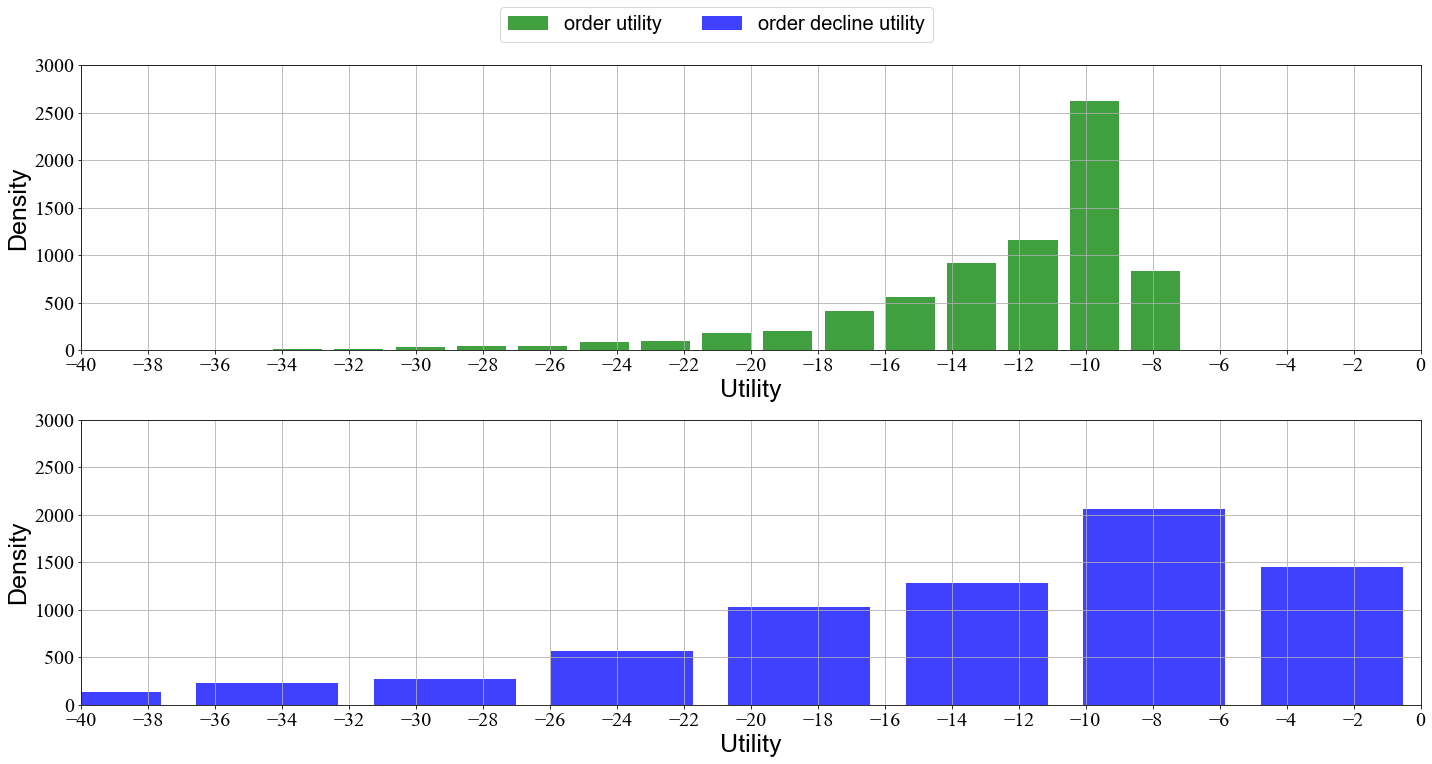

In [12]:
V=copy.deepcopy(np.array(Order_df['V'].to_list()))

V_d=copy.deepcopy(np.array(Order_df['V_d'].to_list()))

'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Platform A'''

ax1[0].hist(V,20,label='order utility',facecolor='g', density=False, alpha=0.75,rwidth=0.8)

    
xmajorLocator   = MultipleLocator(2)

ax1[0].xaxis.set_major_locator(xmajorLocator)


ax1[0].set_ylabel('Density',font_label)

ax1[0].set_xlabel('Utility',font_label)

ax1[0].grid()

ax1[0].set_xlim([-40,0])

ax1[0].set_ylim([0,3000])


'''Platform A'''

ax1[1].hist(V_d,20,label='order decline utility',facecolor='b', density=False, alpha=0.75,rwidth=0.8)
    
xmajorLocator = MultipleLocator(2)

ax1[1].xaxis.set_major_locator(xmajorLocator)


ax1[1].set_ylabel('Density',font_label)

ax1[1].set_xlabel('Utility',font_label)

ax1[1].grid()

ax1[1].set_xlim([-40,0])

ax1[1].set_ylim([0,3000])


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.07),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

plt.show()

## 03 Drivers' utility


\begin{equation}
u_{o,d}^{i} = (1-w_{d}^{i}) \cdot f_{o}^{i}  - \tau_{o,d} \cdot \beta_{3}
\label{eq:driver utility}
\end{equation}


\begin{equation}
u_{c,d} = \beta_{4}\cdot T_{o}
\label{eq:driver decline utility}
\end{equation}

In [13]:
'''Take platform A as an example'''

'''

Speed=0.33 km/minute

Dispatching radius = 2km

Average Tau =  1 km / 0.33

'''

w=0.2

tau=3

Order_df['U']=Order_df.apply(lambda x:(1-w)*x['Fare']-Truncated_Gauss(0.4,0.1,0.3,0.5)*tau,axis=1)
                             
Order_df['U_d']=Order_df.apply(lambda x:Truncated_Gauss(0.6,0.1,0.5,0.7)*x['Travel_minute'],axis=1)

Order_df




,Order_id,Driver_id,Arrive_step,Response_step,Pickup_step,Pickup_Latitude,Pickup_Longitude,Dropoff_Latitude,Dropoff_Longitude,Pickup_Grid,...,Fare,Travel_duration,Travel_distance,Fare_A,Fare_B,Travel_minute,V,V_d,U,U_d
0,O3164,Waiting,2520,86400,86400,40.754468,-73.964315,40.741961,-73.977330,892a100d6afffff,...,7.608736,7,1.490707,6.5,7.0,7,-10.608736,-14.0,6.086989,7.0
1,O3023,Waiting,2520,86400,86400,40.761293,-73.969216,40.705866,-74.015789,892a100d617ffff,...,22.812854,28,5.978774,17.0,13.7,28,-22.812854,-56.0,18.250283,28.0
2,O1659,Waiting,2520,86400,86400,40.793813,-73.956710,40.755719,-73.987493,892a1008d6bffff,...,16.278213,19,4.044693,12.5,10.1,19,-16.278213,-19.0,13.022570,19.0
3,O2033,Waiting,2520,86400,86400,40.746387,-73.991349,40.769579,-73.956629,892a100d2cfffff,...,14.184315,16,3.448180,11.0,8.9,16,-14.184315,-16.0,11.347452,16.0
4,O3016,Waiting,2520,86400,86400,40.744064,-73.988888,40.759098,-73.968666,892a100d21bffff,...,9.691571,10,2.080898,8.0,7.0,10,-12.691571,-10.0,7.753257,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7222,O7096,Waiting,3599,86400,86400,40.753147,-73.999529,40.773106,-73.985229,892a1072523ffff,...,9.248439,9,2.027679,7.5,7.0,9,-12.248439,-9.0,7.398751,9.0
7223,O11395,Waiting,3599,86400,86400,40.747148,-74.002871,40.719936,-73.990109,892a1072197ffff,...,11.093741,12,2.482138,9.0,7.3,12,-14.093741,-12.0,8.874993,12.0
7224,O9044,Waiting,3599,86400,86400,40.740831,-73.986430,40.761017,-73.981455,892a100d203ffff,...,8.354597,8,1.716913,7.0,7.0,8,-11.354597,-16.0,6.683678,8.0
7225,O10529,Waiting,3599,86400,86400,40.777589,-73.965240,40.748137,-73.979418,892a1008973ffff,...,11.824051,13,2.699458,9.5,7.7,13,-14.824051,-26.0,9.459241,13.0


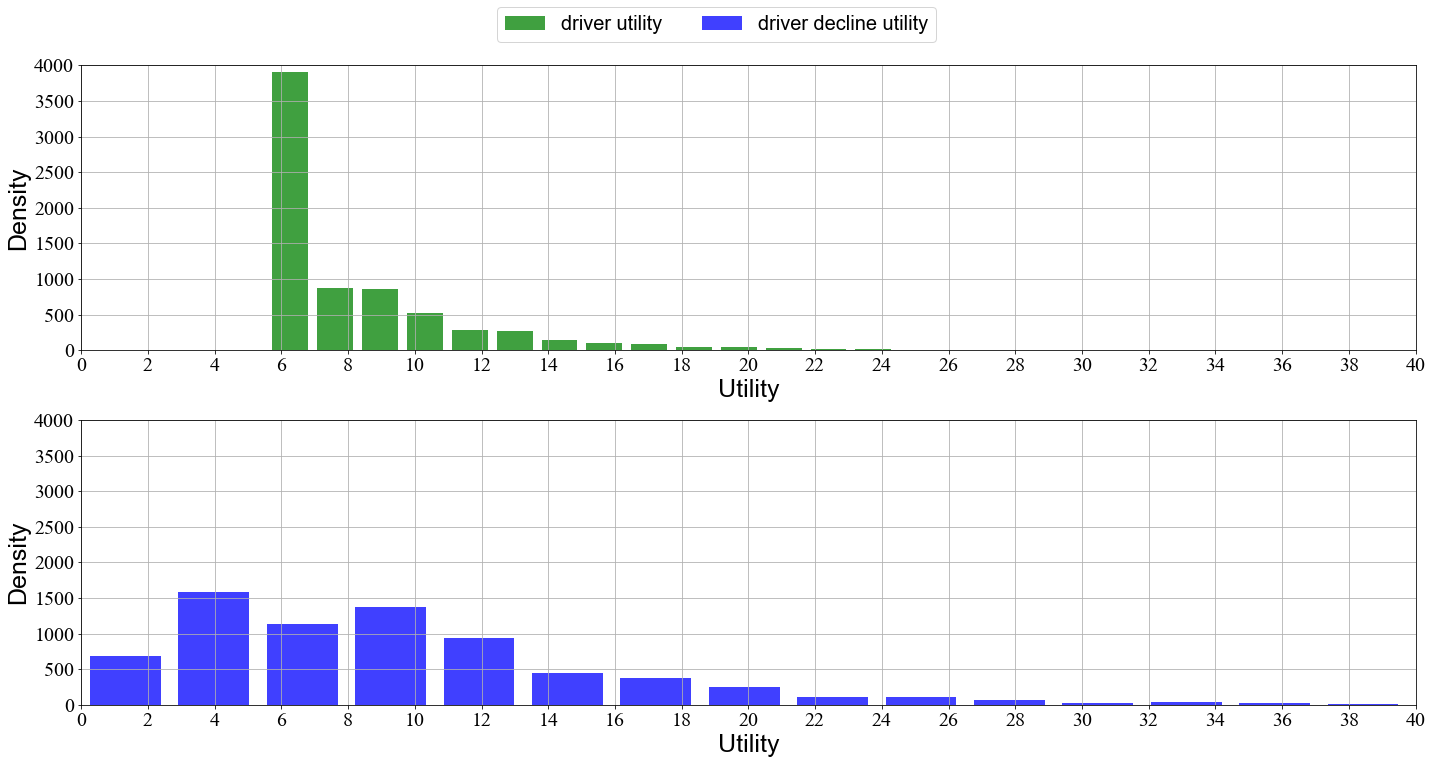

In [15]:
U=copy.deepcopy(np.array(Order_df['U'].to_list()))

U_d=copy.deepcopy(np.array(Order_df['U_d'].to_list()))

'''Plot Figure'''

figsize = 20,10

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(2,1,figsize=figsize)

for i in range(2):

    labels = ax1[i].get_xticklabels() + ax1[i].get_yticklabels()

    [label.set_fontsize(20) for label in labels]

    [label.set_fontname('Times New Roman') for label in labels]
    
    
    

'''Platform A'''

ax1[0].hist(U,20,label='driver utility',facecolor='g', density=False, alpha=0.75,rwidth=0.8)

    
xmajorLocator   = MultipleLocator(2)

ax1[0].xaxis.set_major_locator(xmajorLocator)


ax1[0].set_ylabel('Density',font_label)

ax1[0].set_xlabel('Utility',font_label)

ax1[0].grid()

ax1[0].set_xlim([0,40])

ax1[0].set_ylim([0,4000])


'''Platform A'''

ax1[1].hist(U_d,20,label='driver decline utility',facecolor='b', density=False, alpha=0.75,rwidth=0.8)
    
xmajorLocator = MultipleLocator(2)

ax1[1].xaxis.set_major_locator(xmajorLocator)


ax1[1].set_ylabel('Density',font_label)

ax1[1].set_xlabel('Utility',font_label)

ax1[1].grid()

ax1[1].set_xlim([0,40])

ax1[1].set_ylim([0,4000])


lines = []

labels = []

for ax in figure.axes:
    
    axLine, axLabel = ax.get_legend_handles_labels()
    
    lines.extend(axLine)
    
    labels.extend(axLabel)

figure.legend(lines, labels,loc ='upper center',bbox_to_anchor=(0.5, 1.07),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

plt.show()